In [1]:
# 그래픽 카드 확인

!nvidia-smi

Mon Apr  8 05:17:37 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.73       Driver Version: 472.12       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0B:00.0  On |                  N/A |
|  0%   55C    P5    40W / 170W |    977MiB / 12288MiB |    ERR!      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# 필요한 라이브러리 임포트

from tqdm import trange

from collections import Counter

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import tensorflow as tf

tf.__version__

'1.15.8'

In [3]:
# 데이터 불러오기

train = pd.read_csv('/home/sjt/space/projects/dacon_/202403_소득예측AI해커톤/data/train.csv')
test = pd.read_csv('/home/sjt/space/projects/dacon_/202403_소득예측AI해커톤/data/test.csv')
sub = pd.read_csv('/home/sjt/space/projects/dacon_/202403_소득예측AI해커톤/data/sample_submission.csv')

In [4]:
수치형변수 = [
    'Age',
    'Working_Week (Yearly)',
    'Gains',
    'Losses',
    'Dividends'
]

카테고리형변수 = [
    'Gender',
    'Education_Status',
    'Employment_Status',
    'Industry_Status',
    'Occupation_Status',
    'Race',
    'Hispanic_Origin',
    'Martial_Status',
    'Household_Status',
    'Household_Summary',
    'Citizenship',
    'Birth_Country',
    'Birth_Country (Father)',
    'Birth_Country (Mother)',
    'Tax_Status',
    'Income_Status'
]

In [5]:
# 무조건 income 이 0인 애들 마스크
# 이상치 제거

m_train_age = train['Age'] < 15
m_train_Education_Status = train['Education_Status'] == 'Children'
m_train_Employment_Status = train['Employment_Status'] == 'Not Working'
m_train_Industry_Status_1 = train['Industry_Status'] == 'Armed Forces'
m_train_Industry_Status_2 = train['Industry_Status'] == 'Not in universe or children'
m_train_Occupation_Status_1 = train['Occupation_Status'] == 'Armed Forces'
m_train_Occupation_Status_2 = train['Occupation_Status'] == 'Unknown'

m_train = m_train_age | m_train_Education_Status | m_train_Employment_Status | m_train_Industry_Status_1 | m_train_Industry_Status_2 | m_train_Occupation_Status_1 | m_train_Occupation_Status_2

m_test_age = test['Age'] < 15
m_test_Education_Status = test['Education_Status'] == 'Children'
m_test_Employment_Status = test['Employment_Status'] == 'Not Working'
m_test_Industry_Status_1 = test['Industry_Status'] == 'Armed Forces'
m_test_Industry_Status_2 = test['Industry_Status'] == 'Not in universe or children'
m_test_Occupation_Status_1 = test['Occupation_Status'] == 'Armed Forces'
m_test_Occupation_Status_2 = test['Occupation_Status'] == 'Unknown'

m_test = m_test_age | m_test_Education_Status | m_test_Employment_Status | m_test_Industry_Status_1 | m_test_Industry_Status_2 | m_test_Occupation_Status_1 | m_test_Occupation_Status_2

train[m_train].shape, test[m_test].shape

((4719, 23), (2328, 22))

In [6]:
Q1 = train[~m_train]['Income'].quantile(0.25)
Q3 = train[~m_train]['Income'].quantile(0.75)
IQR = Q3 - Q1
rev_range = 3

Q1 - rev_range * IQR, Q3 + rev_range * IQR

(-3000.0, 4000.0)

In [7]:
m_train_age = train['Age'] < 15
m_train_Education_Status = train['Education_Status'] == 'Children'
m_train_Employment_Status = train['Employment_Status'] == 'Not Working'
m_train_Industry_Status_1 = train['Industry_Status'] == 'Armed Forces'
m_train_Industry_Status_2 = train['Industry_Status'] == 'Not in universe or children'
m_train_Occupation_Status_1 = train['Occupation_Status'] == 'Armed Forces'
m_train_Occupation_Status_2 = train['Occupation_Status'] == 'Unknown'
m_train_Income = train['Income'] > 4000.0

m_train = m_train_age | m_train_Education_Status | m_train_Employment_Status | m_train_Industry_Status_1 | m_train_Industry_Status_2 | m_train_Occupation_Status_1 | m_train_Occupation_Status_2 | m_train_Income
train[m_train].shape

(4781, 23)

In [10]:
# target encoding

'''dic_train = dict()

for i in 카테고리형변수:
    _ = train[~m_train][[i,'Income']].groupby(i).median().round(0).reset_index()
    dic_train.update(dict(zip(_[i],_['Income'])))

def targetencoding(x):
    try:
        return dic_train[x]
    except:
        return 701

df_학습데이터 = train[~m_train].copy()

for i in 카테고리형변수:
    df_학습데이터[i] = df_학습데이터[i].apply(lambda x : targetencoding(x))

df_학습데이터_Y = df_학습데이터['Income'].copy()
df_학습데이터_X = df_학습데이터.drop(['Income','ID'],axis=1)

df_학습데이터_X = np.log(df_학습데이터_X+1)

df_학습데이터_X'''

,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,Martial_Status,...,Household_Summary,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status
0,4.158883,6.552508,6.255750,6.481577,1.609438,6.265301,6.216606,6.47851,6.478510,6.566672,...,6.587550,6.47851,6.47851,6.478510,6.478510,6.077642,0.000000,0.0,0.0,6.475433
1,3.637586,6.552508,6.797940,6.481577,3.970292,6.311735,6.216606,6.47851,6.478510,6.478510,...,6.587550,6.47851,6.47851,6.478510,6.478510,6.398595,0.000000,0.0,0.0,6.470800
2,4.077537,6.398595,6.552508,6.481577,3.970292,6.552508,6.598509,6.43935,6.478510,6.566672,...,6.587550,6.47851,6.47851,6.478510,6.478510,6.587550,8.135054,0.0,0.0,6.470800
3,3.806662,6.552508,6.552508,6.481577,3.970292,6.216606,6.871091,6.47851,6.478510,6.552508,...,6.587550,6.47851,6.47851,6.478510,6.478510,6.398595,0.000000,0.0,0.0,6.470800
4,3.637586,6.398595,6.552508,6.481577,3.970292,6.216606,6.216606,6.47851,6.478510,6.552508,...,6.587550,6.47851,6.47851,6.478510,6.478510,6.478510,0.000000,0.0,0.0,6.475433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19993,3.737670,6.552508,6.552508,6.481577,3.970292,6.216606,6.216606,6.47851,6.478510,6.478510,...,6.587550,6.47851,6.47851,6.478510,6.478510,6.398595,0.000000,0.0,0.0,6.470800
19995,3.526361,6.552508,6.552508,6.424869,3.970292,6.765039,6.368187,6.47851,6.478510,6.398595,...,6.587550,6.47851,6.47851,6.478510,6.478510,6.398595,0.000000,0.0,0.0,6.470800
19996,3.044522,6.398595,6.478510,6.481577,2.564949,6.265301,6.598509,6.47851,6.311735,6.398595,...,6.265301,6.47851,6.47851,6.216606,6.216606,6.077642,0.000000,0.0,0.0,6.470800
19997,3.135494,6.552508,6.478510,6.424869,3.970292,6.685861,6.871091,6.47851,6.478510,6.398595,...,6.196444,6.47851,6.47851,6.478510,6.478510,6.398595,0.000000,0.0,0.0,6.475433


In [9]:
poly = PolynomialFeatures()
df_파생변수 = pd.DataFrame(poly.fit_transform(train[~m_train][수치형변수]), index=train[~m_train].index, columns=poly.get_feature_names_out())

def 원핫인코딩(관심카테고리):
    ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
    train_관심카테고리 = ohe.fit_transform(train[[관심카테고리]])
    test_관심카테고리 = ohe.transform(test[[관심카테고리]])
    df_train_원핫인코딩 = pd.DataFrame(train_관심카테고리, columns=[관심카테고리 + '_' + i for i in ohe.categories_[0]])
    df_test_원핫인코딩 = pd.DataFrame(test_관심카테고리, columns=[관심카테고리 + '_' + i for i in ohe.categories_[0]])
    return [df_train_원핫인코딩,df_test_원핫인코딩]

df_train_원핫인코딩 = pd.DataFrame()
df_test_원핫인코딩 = pd.DataFrame()

for i in 카테고리형변수:
    r = 원핫인코딩(i)
    df_train_원핫인코딩 = pd.concat([df_train_원핫인코딩, r[0]], axis=1)
    df_test_원핫인코딩 = pd.concat([df_test_원핫인코딩, r[1]], axis=1)

df_학습데이터 = pd.concat([train[~m_train][수치형변수],df_train_원핫인코딩[~m_train]], axis=1)

df_학습데이터['Gains'] = np.log(df_학습데이터['Gains']+1)
df_학습데이터['Losses'] = np.log(df_학습데이터['Losses']+1)
df_학습데이터['Dividends'] = np.log(df_학습데이터['Dividends']+1)

df_학습데이터

,Age,Working_Week (Yearly),Gains,Losses,Dividends,Gender_F,Gender_M,Education_Status_Associates degree (Academic),Education_Status_Associates degree (Vocational),Education_Status_Bachelors degree,...,Birth_Country (Mother)_Yugoslavia,Tax_Status_Head of Household (HOH),Tax_Status_Married Filling Jointly both over 65 (MFJ),Tax_Status_Married Filling Jointly both under 65 (MFJ),Tax_Status_Married Filling Jointly one over 65 & one under 65 (MFJ),Tax_Status_Nonfiler,Tax_Status_Single,Income_Status_Over Median,Income_Status_Under Median,Income_Status_Unknown
0,63,4,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,37,52,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,58,52,8.135054,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,44,52,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,37,52,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19993,41,52,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
19995,33,52,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
19996,20,12,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
19997,22,52,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [11]:
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print("")
        print(".", end="")


input_shape = df_학습데이터_X.shape[1]

earty_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=100)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            64*4,
            input_shape=[input_shape],
            kernel_regularizer=tf.keras.regularizers.l2(0.001),
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.8),

        tf.keras.layers.Dense(
            64*3,
            kernel_regularizer=tf.keras.regularizers.l2(0.001),
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.8),

        tf.keras.layers.Dense(
            64*2,
            kernel_regularizer=tf.keras.regularizers.l2(0.001),
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.8),

        tf.keras.layers.Dense(
            64,
            kernel_regularizer=tf.keras.regularizers.l2(0.001),
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.8),

        tf.keras.layers.Dense(
            64,
            kernel_regularizer=tf.keras.regularizers.l2(0.001),
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.8),

        tf.keras.layers.Dense(
            64,
            kernel_regularizer=tf.keras.regularizers.l2(0.001),
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.8),

        tf.keras.layers.Dense(1),
    ]
)

# lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#     0.001, decay_steps=1419 * 1000, decay_rate=1, staircase=False
# )

# optimizer = tf.keras.optimizers.Adam(lr_schedule)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss="mse",
    metrics=["mse", tf.keras.metrics.RootMeanSquaredError()],
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5632      
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 192)               49344     
_________________________________________________________________
batch_normalization_1 (Batch (None, 192)               768       
_________________________________________________________________
activation_1 (Activation)    (None, 192)               0

NVD3D10: CPU cyclestats are disabled on client virtualization 
NVD3D10: CPU cyclestats are disabled on client virtualization 
NVD3D10: CPU cyclestats are disabled on client virtualization 
NVD3D10: CPU cyclestats are disabled on client virtualization 


2024-04-08 05:20:05.518839: I tensorflow/stream_executor/platform/default/dso_loader.cc:97] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-04-08 05:20:05.518892: I tensorflow/stream_executor/platform/default/dso_loader.cc:97] Successfully opened dynamic library libdxcore.so
2024-04-08 05:20:05.520745: I tensorflow/stream_executor/platform/default/dso_loader.cc:97] Successfully opened dynamic library libd3d12.so
2024-04-08 05:20:05.722145: I tensorflow/core/common_runtime/dml/dml_device_cache.cc:250] DirectML device enumeration: found 1 compatible adapters.
2024-04-08 05:20:05.722924: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-04-08 05:20:05.723549: I tensorflow/core/common_runtime/dml/dml_device_cache.cc:186] DirectML: creating device on adapter 0 (NVIDIA GeForce RTX 3060)



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............

,loss,mean_squared_error,root_mean_squared_error,val_loss,val_mean_squared_error,val_root_mean_squared_error
708,345199.805938,345168.87500,587.510742,309998.894718,309968.03125,556.747742
709,347082.647636,347051.96875,589.111145,312291.192558,312260.34375,558.802612
710,345369.193342,345338.43750,587.655029,310387.665620,310356.78125,557.096741
711,346672.894713,346641.87500,588.763000,309020.814629,308989.87500,555.868591
712,348311.510211,348280.75000,590.153137,309679.980248,309649.06250,556.461182


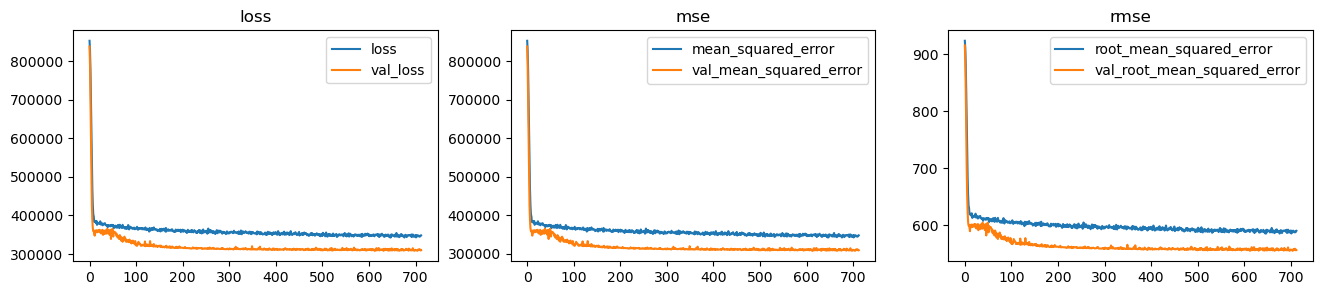

In [13]:
history = model.fit(df_학습데이터_X, df_학습데이터_Y, validation_split=0.3, epochs=1000, callbacks=[earty_stop, PrintDot()], verbose=0)
df_hist = pd.DataFrame(history.history)

fig, axs = plt.subplots(1, 3, figsize=(16,3))

df_hist[['loss', 'val_loss']].plot(ax=axs[0], title='loss')
df_hist[['mean_squared_error', 'val_mean_squared_error']].plot(ax=axs[1], title='mse')
df_hist[['root_mean_squared_error', 'val_root_mean_squared_error']].plot(ax=axs[2], title='rmse');

df_hist.tail()

In [15]:
df_평가데이터 = pd.concat([test[수치형변수][~m_test],df_test_원핫인코딩[~m_test]], axis=1)

df_평가데이터['Gains'] = np.log(df_평가데이터['Gains']+1)
df_평가데이터['Losses'] = np.log(df_평가데이터['Losses']+1)
df_평가데이터['Dividends'] = np.log(df_평가데이터['Dividends']+1)

df_평가데이터

,Age,Working_Week (Yearly),Gains,Losses,Dividends,Gender_F,Gender_M,Education_Status_Associates degree (Academic),Education_Status_Associates degree (Vocational),Education_Status_Bachelors degree,...,Birth_Country (Mother)_Yugoslavia,Tax_Status_Head of Household (HOH),Tax_Status_Married Filling Jointly both over 65 (MFJ),Tax_Status_Married Filling Jointly both under 65 (MFJ),Tax_Status_Married Filling Jointly one over 65 & one under 65 (MFJ),Tax_Status_Nonfiler,Tax_Status_Single,Income_Status_Over Median,Income_Status_Under Median,Income_Status_Unknown
2,18,52,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,39,30,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,31,24,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,17,51,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
9,43,52,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,17,52,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
9995,31,52,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
9996,27,52,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9997,18,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [16]:
result = model.predict(df_평가데이터)

In [17]:
df_result = pd.DataFrame(result, index=df_평가데이터.index, columns=['Income'])
df_m_test = pd.DataFrame([0 for i in range(10000)], columns=['Income'])[m_test]
df_result = pd.concat([df_result, df_m_test]).sort_index().round()
df_result

,Income
0,0.0
1,0.0
2,300.0
3,567.0
4,0.0
...,...
9995,739.0
9996,606.0
9997,302.0
9998,0.0


In [18]:
sub['Income'] = df_result['Income']
sub

,ID,Income
0,TEST_0000,0.0
1,TEST_0001,0.0
2,TEST_0002,300.0
3,TEST_0003,567.0
4,TEST_0004,0.0
...,...,...
9995,TEST_9995,739.0
9996,TEST_9996,606.0
9997,TEST_9997,302.0
9998,TEST_9998,0.0


In [19]:
sub.to_csv('tensorflow_4.csv', index=False)